In [11]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from config import config

connection = mysql.connector.connect(
    host=config.get('HOST'),
    user=config.get('USERNAME'),
    password=config.get('PASSWORD'),
    database=config.get('DATABASE')
)

cursor = connection.cursor()

In [12]:
start_datee = '2019-09-01 00:00:00'
end_datee = '2019-12-31 23:59:59'

In [13]:
# get the text from conversations query
""" 
SELECT tweets.text
FROM tweets
JOIN hasher ON hasher.id = tweets.id
JOIN conversations ON hasher.conversation_id = conversations.conversation_id
WHERE conversations.conversation_id IN (1, 2, 3)
"""

' \nSELECT tweets.text\nFROM tweets\nJOIN hasher ON hasher.id = tweets.id\nJOIN conversations ON hasher.conversation_id = conversations.conversation_id\nWHERE conversations.conversation_id IN (1, 2, 3)\n'

In [14]:
# Conversation length descriptive statistics
conv_length = f"""
SELECT length 
FROM conversations 
WHERE conversation_id NOT IN (
        SELECT conversation_id 
        FROM conversations 
        WHERE start <1500000000000 
            OR end <1500000000000)
    AND start >= UNIX_TIMESTAMP('{start_datee}') * 1000
    AND start <= UNIX_TIMESTAMP('{end_datee}') * 1000;
"""

df = pd.read_sql(conv_length, connection)

descriptive_conv_length_stats = df['length'].describe() # Compute the descriptive statistics

descriptive_conv_length_stats_df = descriptive_conv_length_stats.to_frame().T # Represent it as a data frame

descriptive_conv_length_stats_df

/var/folders/_1/64lzdpgn2472v4xdvl_3y1l40000gn/T/ipykernel_12110/2473851308.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(conv_length, connection)


,count,mean,std,min,25%,50%,75%,max
length,265246.0,2.54693,1.763617,1.0,2.0,2.0,3.0,76.0


In [15]:
# Extract conversation starts time units for all connversations
conv_start = f"""
SELECT start 
FROM conversations 
WHERE conversation_id NOT IN (
        SELECT conversation_id 
        FROM conversations 
        WHERE start <1500000000000 
            OR end <1500000000000) 
    AND start >= UNIX_TIMESTAMP('{start_datee}') * 1000
    AND start <= UNIX_TIMESTAMP('{end_datee}') * 1000;
"""

df_start = pd.read_sql(conv_start, connection)

df_start['start'] = pd.to_datetime(df_start['start'], unit='ms') # Convert timestamp to a date time format

df_start['hour'] = df_start['start'].dt.hour # Extract the hour when the conv starts

df_start['day_of_month'] = df_start['start'].dt.day # Extract the day of the month

df_start['day_of_week'] = df_start['start'].dt.dayofweek # Extract the day when the conv starts

df_start['month'] = df_start['start'].dt.month # Extract the month when the conv starts

/var/folders/_1/64lzdpgn2472v4xdvl_3y1l40000gn/T/ipykernel_12110/2563037356.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_start = pd.read_sql(conv_start, connection)


/Users/jangalic04/anaconda3/envs/JB1010/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jangalic04/anaconda3/envs/JB1010/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jangalic04/anaconda3/envs/JB1010/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


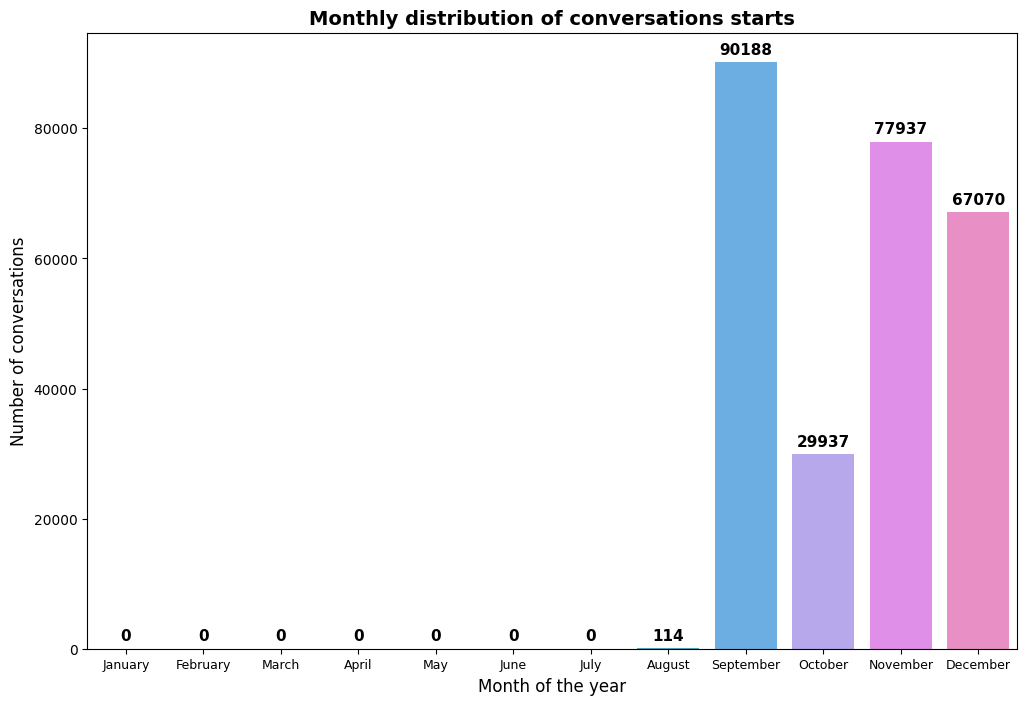

In [16]:
# Monthly distribution of conversation starts

monthly_distribution = df_start['month'].value_counts().reindex(range(1, 13), fill_value=0).sort_index() # Count the number of conversations starting on each month

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=monthly_distribution.index, y=monthly_distribution.values)
plt.xlabel('Month of the year', fontsize=12)
plt.ylabel('Number of conversations', fontsize=12)
plt.title('Monthly distribution of conversations starts', fontsize=14, weight='bold')
plt.xticks(range(12), ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], fontsize = 9)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=11, weight='bold', color='black')

plt.show()

In [17]:
# Conversation length descriptive statistics
conv_duration = f"""
SELECT start, end 
FROM conversations 
WHERE length > 1
    AND conversation_id NOT IN (
        SELECT conversation_id 
        FROM conversations 
        WHERE start <1500000000000 
            OR end <1500000000000)
    AND start >= UNIX_TIMESTAMP('{start_datee}') * 1000
    AND start <= UNIX_TIMESTAMP('{end_datee}') * 1000;
"""

df_duration = pd.read_sql(conv_duration, connection)

df_duration['start'] = pd.to_datetime(df_duration['start'], unit='ms') # Convert timestamp to date time format
df_duration['end'] = pd.to_datetime(df_duration['end'], unit='ms') # Convert timestamp to date time format

df_duration['duration'] = (df_duration['end'] - df_duration['start']).dt.total_seconds() # Compute the duration of conversations in seconds

df_duration['duration_in_hours'] = df_duration['duration'] / 3600

duration_desc_stats = df_duration['duration_in_hours'].describe() # Compute the descriptive statistics of conversations durations
df_duration_desc_stats = duration_desc_stats.to_frame().T
df_duration_desc_stats = df_duration_desc_stats.drop(columns="count")

df_duration_desc_stats

/var/folders/_1/64lzdpgn2472v4xdvl_3y1l40000gn/T/ipykernel_12110/4204465844.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_duration = pd.read_sql(conv_duration, connection)


,mean,std,min,25%,50%,75%,max
duration_in_hours,29.02089,163.572387,0.000044,0.413893,1.9866,10.864053,4911.677341


In [20]:
# Conversation length descriptive statisticss for each airline
def compute_descriptive_stats(query, connection):
    df = pd.read_sql(query, connection)

    descriptive_stats = df['length'].describe() # Compute descriptive statistics

    descriptive_stats_df = descriptive_stats.to_frame().T # Convert to a data frame

    return descriptive_stats_df

british_airways_conv_length_query = f"""
SELECT DISTINCT conversations.conversation_id, conversations.length
FROM conversations
JOIN hasher ON hasher.conversation_id = conversations.conversation_id
JOIN tweets ON hasher.id = tweets.id 
WHERE (tweets.user_mentions LIKE '%18332190%' 
    OR tweets.mentioned_airlines LIKE '%British_Airways%' 
    OR conversations.airline LIKE '%British_Airways%')
    AND conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000
    AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000;
"""
KLM_conv_length_query = f""" 
SELECT DISTINCT conversations.conversation_id, conversations.length
FROM conversations
JOIN hasher ON hasher.conversation_id = conversations.conversation_id
JOIN tweets ON hasher.id = tweets.id 
WHERE (tweets.user_mentions LIKE '%56377143%' 
    OR tweets.mentioned_airlines LIKE '%KLM%' 
    OR conversations.airline LIKE '%KLM%')
    AND conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000
    AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000;
"""
lufthansa_conv_length_query = f""" 
SELECT DISTINCT conversations.conversation_id, conversations.length
FROM conversations
JOIN hasher ON hasher.conversation_id = conversations.conversation_id
JOIN tweets ON hasher.id = tweets.id 
WHERE (tweets.user_mentions LIKE '%124476322%' 
    OR tweets.mentioned_airlines LIKE '%lufthansa%' 
    OR conversations.airline LIKE '%lufthansa%')
    AND conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000
    AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000;
"""
air_france_conv_length_query = f""" 
SELECT DISTINCT conversations.conversation_id, conversations.length
FROM conversations
JOIN hasher ON hasher.conversation_id = conversations.conversation_id
JOIN tweets ON hasher.id = tweets.id 
WHERE (tweets.user_mentions LIKE '%106062176%' 
    OR tweets.mentioned_airlines LIKE '%AirFrance%' 
    OR conversations.airline LIKE '%AirFrance%')
    AND conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000
    AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000;
"""

descriptive_british_airways_conv_length_stats_df = compute_descriptive_stats(british_airways_conv_length_query, connection)
descriptive_KLM_conv_length_stats_df = compute_descriptive_stats(KLM_conv_length_query, connection)
descriptive_lufthansa_conv_length_stats_df = compute_descriptive_stats(lufthansa_conv_length_query, connection)
descriptive_air_france_conv_length_stats_df = compute_descriptive_stats(air_france_conv_length_query, connection)

desc_conv_length_stats_per_airline = pd.concat([descriptive_british_airways_conv_length_stats_df, descriptive_KLM_conv_length_stats_df, descriptive_lufthansa_conv_length_stats_df, descriptive_air_france_conv_length_stats_df])

desc_conv_length_stats_per_airline

/var/folders/_1/64lzdpgn2472v4xdvl_3y1l40000gn/T/ipykernel_12110/864047355.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)
/var/folders/_1/64lzdpgn2472v4xdvl_3y1l40000gn/T/ipykernel_12110/864047355.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)
/var/folders/_1/64lzdpgn2472v4xdvl_3y1l40000gn/T/ipykernel_12110/864047355.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)
/var/folders/_1/64lzdpgn2472v4xdvl_3y1l4

,count,mean,std,min,25%,50%,75%,max
length,49646.0,2.863977,2.147621,1.0,2.0,2.0,3.0,76.0
length,14870.0,2.687223,2.712516,1.0,1.0,2.0,3.0,46.0
length,10875.0,2.420966,1.737056,1.0,1.0,2.0,3.0,18.0
length,5680.0,2.596127,2.055641,1.0,2.0,2.0,3.0,37.0


In [22]:
# Extract conversation starts time units for conversations per airline
def extract_time(query, connection):

    df = pd.read_sql(query, connection)

    df['start'] = pd.to_datetime(df['start'], unit='ms') # Convert timestamp to a date time format

    df['hour'] = df['start'].dt.hour # Extract the hour when the conv starts

    df['day_of_month'] = df['start'].dt.day # Extract the day of the month

    df['day_of_week'] = df['start'].dt.dayofweek # Extract the day when the conv starts

    df['month'] = df['start'].dt.month # Extract the month when the conv starts

    return df

british_airways_conv_start_query = f"""
SELECT DISTINCT conversations.conversation_id, conversations.start
FROM conversations
JOIN hasher ON hasher.conversation_id = conversations.conversation_id
JOIN tweets ON hasher.id = tweets.id 
WHERE (tweets.user_mentions LIKE '%18332190%' 
    OR tweets.mentioned_airlines LIKE '%British_Airways%' 
    OR conversations.airline LIKE '%British_Airways%')
    AND conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000
    AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000;
"""
KLM_conv_start_query = f""" 
SELECT DISTINCT conversations.conversation_id, conversations.start
FROM conversations
JOIN hasher ON hasher.conversation_id = conversations.conversation_id
JOIN tweets ON hasher.id = tweets.id 
WHERE (tweets.user_mentions LIKE '%56377143%' 
    OR tweets.mentioned_airlines LIKE '%KLM%' 
    OR conversations.airline LIKE '%KLM%')
    AND conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000
    AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000;
"""
lufthansa_conv_start_query = f""" 
SELECT DISTINCT conversations.conversation_id, conversations.start
FROM conversations
JOIN hasher ON hasher.conversation_id = conversations.conversation_id
JOIN tweets ON hasher.id = tweets.id 
WHERE (tweets.user_mentions LIKE '%124476322%' 
    OR tweets.mentioned_airlines LIKE '%lufthansa%' 
    OR conversations.airline LIKE '%lufthansa%')
    AND conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000
    AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000;
"""
air_france_conv_start_query = f""" 
SELECT DISTINCT conversations.conversation_id, conversations.start
FROM conversations
JOIN hasher ON hasher.conversation_id = conversations.conversation_id
JOIN tweets ON hasher.id = tweets.id 
WHERE (tweets.user_mentions LIKE '%106062176%' 
    OR tweets.mentioned_airlines LIKE '%AirFrance%' 
    OR conversations.airline LIKE '%AirFrance%')
    AND conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000
    AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000;
"""

british_airways_conv_start = extract_time(british_airways_conv_start_query, connection)
KLM_conv_start = extract_time(KLM_conv_start_query, connection)
lufthansa_conv_start = extract_time(lufthansa_conv_start_query, connection)
air_france_conv_start = extract_time(air_france_conv_start_query, connection)

/var/folders/_1/64lzdpgn2472v4xdvl_3y1l40000gn/T/ipykernel_12110/977993928.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)
/var/folders/_1/64lzdpgn2472v4xdvl_3y1l40000gn/T/ipykernel_12110/977993928.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)
/var/folders/_1/64lzdpgn2472v4xdvl_3y1l40000gn/T/ipykernel_12110/977993928.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)
/var/folders/_1/64lzdpgn2472v4xdvl_3y1l4

/Users/jangalic04/anaconda3/envs/JB1010/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jangalic04/anaconda3/envs/JB1010/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jangalic04/anaconda3/envs/JB1010/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jangalic04/anaconda3/envs/JB1010/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

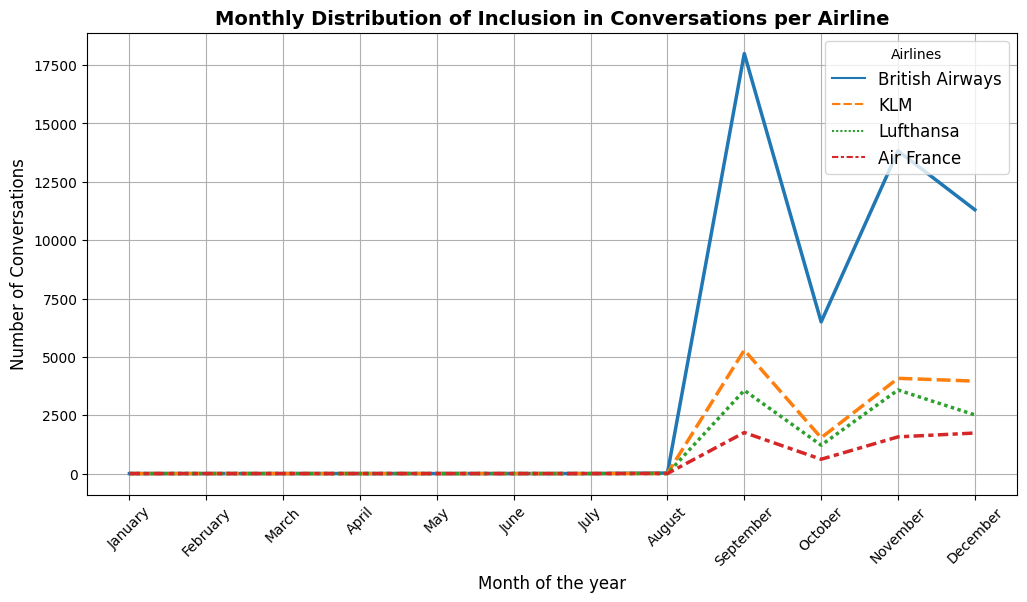

In [23]:
# Count the number of conversations starting each month
british_airways_monthly_distribution = british_airways_conv_start['month'].value_counts().reindex(range(1, 13), fill_value=0).sort_index() 
KLM_monthly_distribution = KLM_conv_start['month'].value_counts().reindex(range(1, 13), fill_value=0).sort_index() 
lufthansa_monthly_distribution = lufthansa_conv_start['month'].value_counts().reindex(range(1, 13), fill_value=0).sort_index() 
air_france_monthly_distribution = air_france_conv_start['month'].value_counts().reindex(range(1, 13), fill_value=0).sort_index()

# Concatenate data frames into one data frame
airlines_monthly_distribution_df = pd.concat([british_airways_monthly_distribution, KLM_monthly_distribution, lufthansa_monthly_distribution, air_france_monthly_distribution], axis = 1)
airlines_monthly_distribution_df.columns = ['British Airways', 'KLM', 'Lufthansa', 'Air France']

# Plot the monthly distribution data frame
plt.figure(figsize=(12, 6))
sns.lineplot(data=airlines_monthly_distribution_df, linewidth=2.5)

plt.title('Monthly Distribution of Inclusion in Conversations per Airline', fontsize=14, weight='bold')
plt.xlabel('Month of the year', fontsize=12)
plt.ylabel('Number of Conversations', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],rotation=45)
plt.legend(title='Airlines', loc='upper right', fontsize=12)
plt.grid(True)

plt.show()

In [24]:
# Compute response times for each airline

# Load data from the databases
conversations = pd.read_sql(f"""
                            SELECT conversation_id, airline 
                            FROM conversations 
                            WHERE start >= UNIX_TIMESTAMP('{start_datee}') * 1000 
                                AND start <= UNIX_TIMESTAMP('{end_datee}') * 1000;
                            """, connection)
tweets = pd.read_sql(f"""
                     SELECT id, user_id, timestamp_ms, in_reply_to_status_id 
                     FROM tweets
                     WHERE timestamp_ms >= UNIX_TIMESTAMP('{start_datee}') * 1000 
                        AND timestamp_ms <= UNIX_TIMESTAMP('{end_datee}') * 1000;
                        """, connection)
hasher = pd.read_sql(f"""
                     SELECT hasher.conversation_id, hasher.id 
                     FROM hasher 
                     JOIN conversations ON hasher.conversation_id = conversations.conversation_id
                     WHERE conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000 
                        AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000;
                        """, connection)

merged_data = hasher.merge(tweets, on='id').merge(conversations, on='conversation_id') # Merge data into one table

merged_data['timestamp_ms'] = pd.to_datetime(merged_data['timestamp_ms'], unit='ms') # Convert timestamp to date time format

british_airways_user_id = 18332190
KLM_user_id = 56377143
lufthansa_user_id = 124476322
air_france_user_id = 106062176

british_airways_responses = merged_data[(merged_data['user_id'] == british_airways_user_id) & (merged_data['in_reply_to_status_id'] != 0)]
KLM_responses = merged_data[(merged_data['user_id'] == KLM_user_id) & (merged_data['in_reply_to_status_id'] != 0)]
lufthansa_responses = merged_data[(merged_data['user_id'] == lufthansa_user_id) & (merged_data['in_reply_to_status_id'] != 0)]
air_france_responses = merged_data[(merged_data['user_id'] == air_france_user_id) & (merged_data['in_reply_to_status_id'] != 0)]

def calculate_average_response_time(responses, merged_data):
    response_times = []

    # Ensure in_reply_to_status_id is numeric
    responses['in_reply_to_status_id'] = pd.to_numeric(responses['in_reply_to_status_id'], errors='coerce')

    # Merge responses with initial tweets
    initial_tweets = merged_data[merged_data['id'].isin(responses['in_reply_to_status_id'])]
    merged_responses = responses.merge(initial_tweets, left_on='in_reply_to_status_id', right_on='id', suffixes=('_response', '_initial'))

    # Check for duplicates
    merged_responses = merged_responses.drop_duplicates(subset=['id_response', 'id_initial'])

    # Calculate response time
    for _, row in merged_responses.iterrows():
        response_time = (row['timestamp_ms_response'] - row['timestamp_ms_initial']).total_seconds()
        response_times.append(response_time / 3600)
    
    return response_times

response_times_british_airways = calculate_average_response_time(british_airways_responses, merged_data)
response_times_KLM = calculate_average_response_time(KLM_responses, merged_data)
response_times_lufthansa = calculate_average_response_time(lufthansa_responses, merged_data)
response_times_air_france = calculate_average_response_time(air_france_responses, merged_data)

/var/folders/_1/64lzdpgn2472v4xdvl_3y1l40000gn/T/ipykernel_12110/651757671.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  conversations = pd.read_sql(f"""
/var/folders/_1/64lzdpgn2472v4xdvl_3y1l40000gn/T/ipykernel_12110/651757671.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  tweets = pd.read_sql(f"""
/var/folders/_1/64lzdpgn2472v4xdvl_3y1l40000gn/T/ipykernel_12110/651757671.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  hasher = pd.read_sql(f"""
/var/folders/_1/64lzdpgn2472v4xdvl_3y1l40000gn/T/ipykernel_12

In [26]:
tot = 0
for i in response_times_air_france:
    tot += i

tot
avg = tot/ len(response_times_air_france)
avg


1.2719150337923981

/Users/jangalic04/anaconda3/envs/JB1010/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jangalic04/anaconda3/envs/JB1010/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jangalic04/anaconda3/envs/JB1010/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


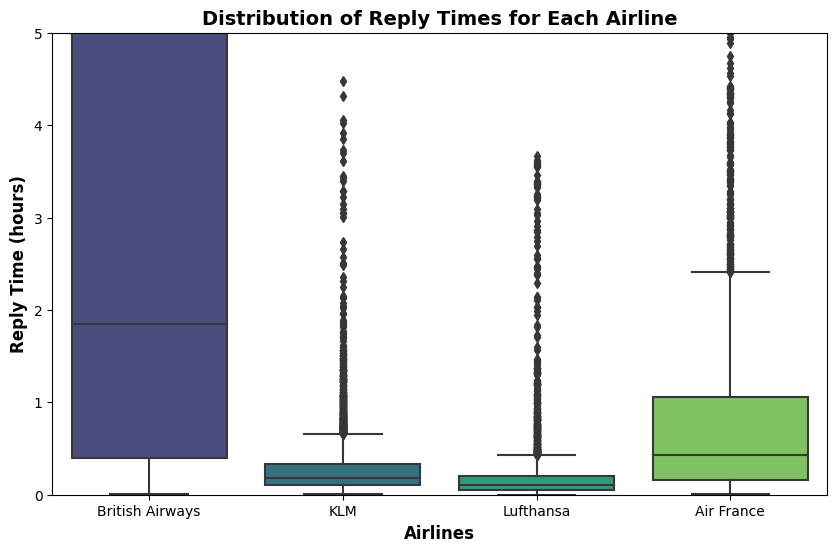

In [25]:
# Box plots for response times for each airline

data = {
    'Airline': (['British Airways'] * len(response_times_british_airways) + 
                ['KLM'] * len(response_times_KLM) + 
                ['Lufthansa'] * len(response_times_lufthansa) + 
                ['Air France'] * len(response_times_air_france)),
    'Reply Time': (response_times_british_airways + 
                   response_times_KLM + 
                   response_times_lufthansa + 
                   response_times_air_france)
}

response_times_df = pd.DataFrame(data)

# Plot the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Airline', y='Reply Time', data=response_times_df, palette='viridis')
plt.xlabel('Airlines', fontsize=12, weight='bold')
plt.ylabel('Reply Time (hours)', fontsize=12, weight='bold')
plt.title('Distribution of Reply Times for Each Airline', fontsize=14, weight='bold')
plt.ylim(0, 5)

# Optionally, show individual data points
#sns.swarmplot(x='Airline', y='Reply Time', data=response_times_df, color=".25")

# Show the plot
plt.show()

In [27]:
def get_count(query):
    cursor = connection.cursor()
    try:
        for result in cursor.execute(query, multi=True):
            if result.with_rows:
                first_result = result.fetchone()
                cursor.fetchall()  # Ensure all remaining rows are fetched
        return first_result[0] if first_result else 0
    finally:
        cursor.close()

In [28]:
# Queries for number of conversations where an airline was mentioned per airline
mentioned_ba = f"""
SELECT COUNT(DISTINCT conversations.conversation_id)
FROM conversations
JOIN hasher ON hasher.conversation_id = conversations.conversation_id
JOIN tweets ON hasher.id = tweets.id
WHERE (tweets.user_mentions LIKE '%18332190%' OR tweets.mentioned_airlines LIKE '%British_Airways%')
    AND conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000 
    AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000; 
"""

mentioned_klm = f""" 
SELECT COUNT(DISTINCT conversations.conversation_id)
FROM conversations
JOIN hasher ON hasher.conversation_id = conversations.conversation_id
JOIN tweets ON hasher.id = tweets.id
WHERE (tweets.user_mentions LIKE '%56377143%' OR tweets.mentioned_airlines LIKE '%KLM%')
    AND conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000 
    AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000; 
"""

mentioned_lufthansa = f""" 
SELECT COUNT(DISTINCT conversations.conversation_id)
FROM conversations
JOIN hasher ON hasher.conversation_id = conversations.conversation_id
JOIN tweets ON hasher.id = tweets.id
WHERE (tweets.user_mentions LIKE '%124476322%' OR tweets.mentioned_airlines LIKE '%Lufthansa%')
    AND conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000 
    AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000; 
"""

mentioned_af = f""" 
SELECT COUNT(DISTINCT conversations.conversation_id)
FROM conversations
JOIN hasher ON hasher.conversation_id = conversations.conversation_id
JOIN tweets ON hasher.id = tweets.id
WHERE (tweets.user_mentions LIKE '%106062176%' OR tweets.mentioned_airlines LIKE '%AirFrance%')
    AND conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000 
    AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000;
"""

In [29]:
# Queries for number of conversations where an airline was mentioned and the airline replied per airline

replies_mentioned_ba = f"""
SELECT COUNT(DISTINCT conversations.conversation_id)
FROM conversations
JOIN hasher ON hasher.conversation_id = conversations.conversation_id
JOIN tweets ON hasher.id = tweets.id
WHERE (tweets.user_mentions LIKE '%18332190%' OR tweets.mentioned_airlines LIKE '%British_Airways%')
    AND conversations.airline LIKE '%British_Airways%'
    AND conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000 
    AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000;
"""

replies_mentioned_klm = f""" 
SELECT COUNT(DISTINCT conversations.conversation_id)
FROM conversations
JOIN hasher ON hasher.conversation_id = conversations.conversation_id
JOIN tweets ON hasher.id = tweets.id
WHERE (tweets.user_mentions LIKE '%56377143%' OR tweets.mentioned_airlines LIKE '%KLM%') 
    AND conversations.airline LIKE '%KLM%'
    AND conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000 
    AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000;
"""

replies_mentioned_lufthansa = f""" 
SELECT COUNT(DISTINCT conversations.conversation_id)
FROM conversations
JOIN hasher ON hasher.conversation_id = conversations.conversation_id
JOIN tweets ON hasher.id = tweets.id
WHERE (tweets.user_mentions LIKE '%124476322%' OR tweets.mentioned_airlines LIKE '%Lufthansa%') 
    AND conversations.airline LIKE '%Lufthansa%'
    AND conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000 
    AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000;
"""

replies_mentioned_af = f""" 
SELECT COUNT(DISTINCT conversations.conversation_id)
FROM conversations
JOIN hasher ON hasher.conversation_id = conversations.conversation_id
JOIN tweets ON hasher.id = tweets.id
WHERE (tweets.user_mentions LIKE '%106062176%' OR tweets.mentioned_airlines LIKE '%AirFrance%')
    AND conversations.airline LIKE '%AirFrance%'
    AND conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000 
    AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000;
"""

In [30]:
# Queries for number of conversations where an airline was mentioned and the airline did not reply per airline

non_replies_where_mentioned_ba = f"""
SELECT COUNT(DISTINCT conversations.conversation_id)
FROM conversations
JOIN hasher ON hasher.conversation_id = conversations.conversation_id
JOIN tweets ON hasher.id = tweets.id
WHERE (tweets.user_mentions LIKE '%18332190%' OR tweets.mentioned_airlines LIKE '%British_Airways%')
  AND conversations.airline NOT LIKE '%British_Airways%'
  AND conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000 
  AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000;
"""

non_replies_where_mentioned_klm = f"""
SELECT COUNT(DISTINCT conversations.conversation_id)
FROM conversations
JOIN hasher ON hasher.conversation_id = conversations.conversation_id
JOIN tweets ON hasher.id = tweets.id
WHERE (tweets.user_mentions LIKE '%56377143%' OR tweets.mentioned_airlines LIKE '%KLM%')
  AND conversations.airline NOT LIKE '%KLM%'
  AND conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000 
  AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000; 
"""

non_replies_where_mentioned_lufthansa = f"""
SELECT COUNT(DISTINCT conversations.conversation_id)
FROM conversations
JOIN hasher ON hasher.conversation_id = conversations.conversation_id
JOIN tweets ON hasher.id = tweets.id
WHERE (tweets.user_mentions LIKE '%124476322%' OR tweets.mentioned_airlines LIKE '%Lufthansa%')
  AND conversations.airline NOT LIKE '%Lufthansa%'
  AND conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000 
  AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000; 
"""

non_replies_where_mentioned_af = f"""
SELECT COUNT(DISTINCT conversations.conversation_id)
FROM conversations
JOIN hasher ON hasher.conversation_id = conversations.conversation_id
JOIN tweets ON hasher.id = tweets.id
WHERE (tweets.user_mentions LIKE '%106062176%' OR tweets.mentioned_airlines LIKE '%AirFrance%')
  AND conversations.airline NOT LIKE '%AirFrance%'
  AND conversations.start >= UNIX_TIMESTAMP('{start_datee}') * 1000 
  AND conversations.start <= UNIX_TIMESTAMP('{end_datee}') * 1000;
"""

In [31]:
mentioned_ba_count = get_count(mentioned_ba)
replies_mentioned_ba_count = get_count(replies_mentioned_ba)
non_replies_where_mentioned_ba_count = get_count(non_replies_where_mentioned_ba)

mentioned_klm_count = get_count(mentioned_klm)
replies_mentioned_klm_count = get_count(replies_mentioned_klm)
non_replies_where_mentioned_klm_count = get_count(non_replies_where_mentioned_klm)

mentioned_lufthansa_count = get_count(mentioned_lufthansa)
replies_mentioned_lufthansa_count = get_count(replies_mentioned_lufthansa)
non_replies_where_mentioned_lufthansa_count = get_count(non_replies_where_mentioned_lufthansa)

mentioned_af_count = get_count(mentioned_af)
replies_mentioned_af_count = get_count(replies_mentioned_af)
non_replies_where_mentioned_af_count = get_count(non_replies_where_mentioned_af)

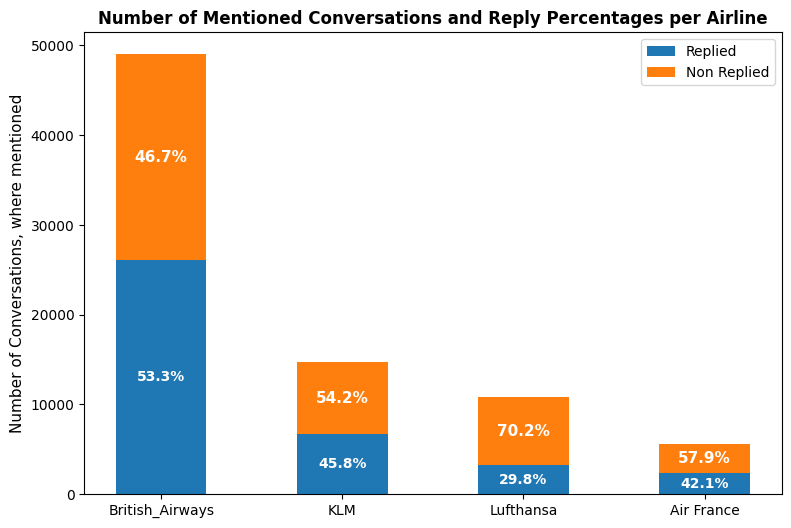

In [32]:
replied_percentage_ba = replies_mentioned_ba_count / mentioned_ba_count * 100
non_replied_percentage_ba = non_replies_where_mentioned_ba_count / mentioned_ba_count * 100

replied_percentage_klm = replies_mentioned_klm_count / mentioned_klm_count * 100
non_replied_percentage_klm = non_replies_where_mentioned_klm_count / mentioned_klm_count * 100

replied_percentage_lufthansa = replies_mentioned_lufthansa_count / mentioned_lufthansa_count * 100
non_replied_percentage_lufthansa = non_replies_where_mentioned_lufthansa_count / mentioned_lufthansa_count * 100

replied_percentage_af = replies_mentioned_af_count / mentioned_af_count * 100
non_replied_percentage_af = non_replies_where_mentioned_af_count / mentioned_af_count * 100

mentioned_convs = [mentioned_ba_count, mentioned_klm_count, mentioned_lufthansa_count, mentioned_af_count]
replied_percentages = [replied_percentage_ba, replied_percentage_klm, replied_percentage_lufthansa, replied_percentage_af]
non_replied_percentages = [non_replied_percentage_ba, non_replied_percentage_klm, non_replied_percentage_lufthansa, non_replied_percentage_af]

replied_counts = [replies_mentioned_ba_count, replies_mentioned_klm_count, replies_mentioned_lufthansa_count, replies_mentioned_af_count]
non_replied_counts = [non_replies_where_mentioned_ba_count, non_replies_where_mentioned_klm_count, non_replies_where_mentioned_lufthansa_count, non_replies_where_mentioned_af_count]

airlines = ['British_Airways', 'KLM', 'Lufthansa', 'Air France']

bar_width = 0.5
ind = range(len(airlines))

fig, ax = plt.subplots(figsize = (9, 6))

p1 = ax.bar(ind, replied_counts, bar_width, label='Replied')
p2 = ax.bar(ind, non_replied_counts, bar_width, bottom=replied_counts, label='Non Replied')

ax.set_ylabel('Number of Conversations, where mentioned', fontsize= 11)
ax.set_title('Number of Mentioned Conversations and Reply Percentages per Airline', fontsize= 12, weight= 'bold')
ax.set_xticks(ind)
ax.set_xticklabels(airlines)
ax.legend(fontsize=10)

for i in range(len(airlines)):
    ax.text(i, replied_counts[i] / 2, f"{replied_percentages[i]:.1f}%", ha='center', va='center', color='white', weight='bold', fontsize=10)
    ax.text(i, replied_counts[i] + non_replied_counts[i] / 2, f"{non_replied_percentages[i]:.1f}%", ha='center', va='center', color='white', weight='bold', fontsize=11)

plt.show()